In [27]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import random
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)

In [30]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

### Пути к директориям и файлам

In [31]:
TRAIN_DATASET_PATH = r'C:\Users\Julia\.jupyter\input\train.csv'
TEST_DATASET_PATH = r'C:\Users\Julia\.jupyter\input\test.csv'
MODEL_FILE_PATH =  r'C:\Users\Julia\.jupyter\models\model.pkl'

## Загрузка данных

Описание датасета

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [32]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
display(train_df.tail())
print(train_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.402,30.476,5.0,6,5.0,1968,0.136,B,B,46,7960,6,350.0,3,11,B,196684.316
9996,6159,18,1.0,41.522,20.539,9.0,13,13.0,2000,0.000,B,B,30,5562,0,NaN,0,5,A,189050.290
9997,5123,27,1.0,47.939,NaN,1.0,12,16.0,2015,0.072,B,B,2,629,1,NaN,0,0,A,159143.805
9998,5400,75,2.0,43.603,33.840,8.0,1,5.0,1961,0.307,B,A,30,5048,9,325.0,2,5,B,181595.340
9999,6306,128,1.0,38.667,21.158,8.0,7,17.0,1990,0.000,B,B,27,4798,0,30.0,2,8,B,218714.078


(10000, 20)


In [33]:
test_df = pd.read_csv(TEST_DATASET_PATH)
display(test_df.tail())
print(test_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.134,50.810,6.0,5,9.0,1973,1.697e-04,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198,21.807,10.0,12,17.0,2017,7.122e-03,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842,48.283,9.0,23,22.0,1989,9.080e-02,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305,NaN,0.0,4,0.0,1977,7.216e-02,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.556,NaN,1.0,10,17.0,1977,7.815e-05,B,B,22,6398,141,1046.0,3,23,B


(5000, 19)


In [34]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


## Приведение типов

In [37]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [38]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## Обзор данных

### Целевая переменная

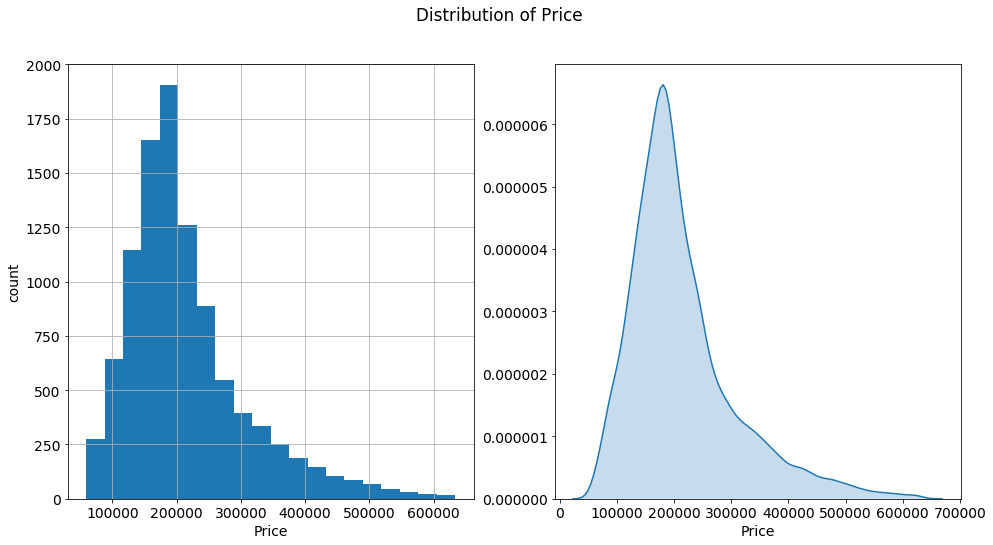

In [39]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

Среднее: 214138.86
Медиана: 192269.64487934904
Мода: 59174.77802758122


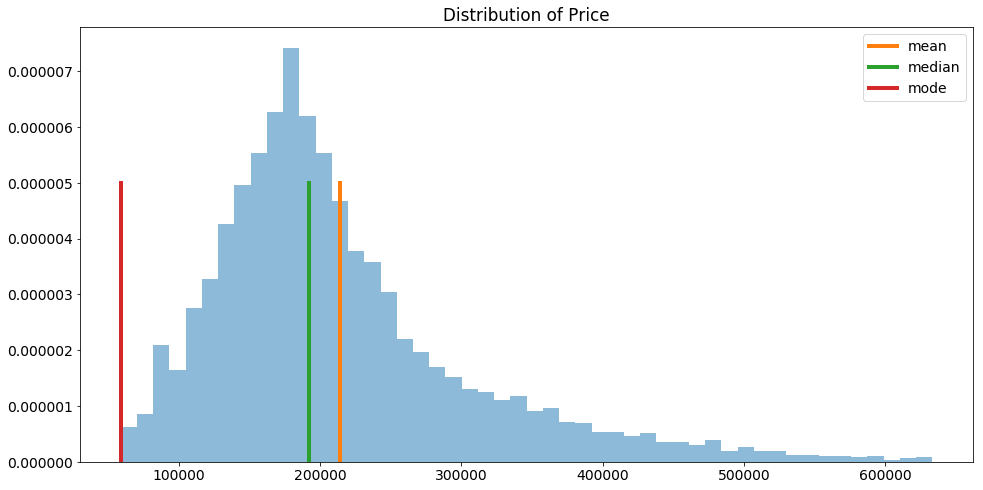

In [40]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

print('Среднее:',target_mean)
print('Медиана:',target_median)
print('Мода:',target_mode)

plt.figure(figsize = (16, 8))
plt.hist(train_df['Price'], density=True, bins=50, alpha=0.5)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

### Количественные переменные

In [41]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.891,0.840,0.000,1.000,2.000,2.000,1.900e+01
Square,10000.0,56.316,21.059,1.137,41.775,52.513,65.901,6.411e+02
LifeSquare,7887.0,37.200,86.241,0.371,22.770,32.781,45.129,7.481e+03
KitchenSquare,10000.0,6.273,28.561,0.000,1.000,6.000,9.000,2.014e+03
Floor,10000.0,8.527,5.241,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,10000.0,12.609,6.776,0.000,9.000,13.000,17.000,1.170e+02
HouseYear,10000.0,3990.166,200500.261,1910.000,1974.000,1977.000,2001.000,2.005e+07
Ecology_1,10000.0,0.119,0.119,0.000,0.018,0.075,0.196,5.219e-01
Social_1,10000.0,24.687,17.533,0.000,6.000,25.000,36.000,7.400e+01
Social_2,10000.0,5352.157,4006.800,168.000,1564.000,5285.000,7227.000,1.908e+04


### Категориальные переменные

In [42]:
category_colnames = train_df.select_dtypes(include='object').columns.tolist()
category_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [43]:
for category_colname in category_colnames[2:]:
    print(str(category_colname) + '\n\n' + str(train_df[category_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

### Rooms

In [44]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [45]:
train_df.loc[train_df['Rooms'].isin([0,6,10,19]),'Rooms'] = train_df['Rooms'].median()

### Square,LifeSquare,KitchenSquare

In [46]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000,10000.000,7887.000,10000.000,10000.000,10000.000,1.000e+04,10000.000,10000.000,10000.000,10000.000,5202.000,10000.000,10000.000,10000.000
mean,1.888,56.316,37.200,6.273,8.527,12.609,3.990e+03,0.119,24.687,5352.157,8.039,1142.904,1.319,4.231,214138.857
std,0.811,21.059,86.241,28.561,5.241,6.776,2.005e+05,0.119,17.533,4006.800,23.832,1021.517,1.494,4.806,92872.294
min,1.000,1.137,0.371,0.000,1.000,0.000,1.910e+03,0.000,0.000,168.000,0.000,0.000,0.000,0.000,59174.778
25%,1.000,41.775,22.770,1.000,4.000,9.000,1.974e+03,0.018,6.000,1564.000,0.000,350.000,0.000,1.000,153872.634
50%,2.000,52.513,32.781,6.000,7.000,13.000,1.977e+03,0.075,25.000,5285.000,2.000,900.000,1.000,3.000,192269.645
75%,2.000,65.901,45.129,9.000,12.000,17.000,2.001e+03,0.196,36.000,7227.000,5.000,1548.000,2.000,6.000,249135.462
max,5.000,641.065,7480.592,2014.000,42.000,117.000,2.005e+07,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000,633233.467


In [47]:
steps = []


In [49]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000,10000.000,7887.000,10000.000,10000.000,10000.000,1.000e+04,10000.000,10000.000,10000.000,10000.000,5202.000,10000.000,10000.000,10000.000
mean,1.888,56.316,37.200,6.273,8.527,12.609,3.990e+03,0.119,24.687,5352.157,8.039,1142.904,1.319,4.231,214138.857
std,0.811,21.059,86.241,28.561,5.241,6.776,2.005e+05,0.119,17.533,4006.800,23.832,1021.517,1.494,4.806,92872.294
min,1.000,1.137,0.371,0.000,1.000,0.000,1.910e+03,0.000,0.000,168.000,0.000,0.000,0.000,0.000,59174.778
25%,1.000,41.775,22.770,1.000,4.000,9.000,1.974e+03,0.018,6.000,1564.000,0.000,350.000,0.000,1.000,153872.634
50%,2.000,52.513,32.781,6.000,7.000,13.000,1.977e+03,0.075,25.000,5285.000,2.000,900.000,1.000,3.000,192269.645
75%,2.000,65.901,45.129,9.000,12.000,17.000,2.001e+03,0.196,36.000,7227.000,5.000,1548.000,2.000,6.000,249135.462
max,5.000,641.065,7480.592,2014.000,42.000,117.000,2.005e+07,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000,633233.467


In [50]:
train_df.loc[train_df['LifeSquare'] < 10,'LifeSquare'] = 10

In [51]:
train_df.loc[train_df['KitchenSquare'] < 3,'KitchenSquare'] = 3

In [53]:
pd.pivot_table(data=train_df,
               values='Square',
               index='Rooms',
               aggfunc='mean')

,Square
Rooms,
1.0,41.323
2.0,56.838
3.0,76.903
4.0,98.378
5.0,122.615


In [54]:
train_df.loc[train_df['Square']>100,'Rooms'] = 5

In [55]:
pd.pivot_table(data=train_df,
               values='Square',
               index='Rooms',
               aggfunc='mean')

,Square
Rooms,
1.0,40.729
2.0,56.321
3.0,74.090
4.0,84.672
5.0,123.088


### HouseFloor,Floor

In [56]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [57]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [58]:
train_df.loc[train_df['HouseFloor']==0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [59]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers,'Floor'] = train_df.loc[floor_outliers,'HouseFloor'].apply(lambda x:random.randint(1,x))

### HouseYear

In [60]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [61]:
train_df.loc[train_df['HouseYear'] > 2020,'HouseYear'] = 2020

### Обработка пропусков

In [62]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### LifeSquare

In [63]:
#медиана до корректировки
train_df['LifeSquare'].median()

32.781260192155735

In [64]:
#медиана расхождения площадей
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(),'Square']
                   - train_df.loc[train_df['LifeSquare'].notnull(),'LifeSquare']
                   - train_df.loc[train_df['LifeSquare'].notnull(),'KitchenSquare']).median()
square_med_diff

11.361443422298542

In [65]:
train_df.loc[train_df['LifeSquare'].isnull(),'LifeSquare'] = (
    train_df.loc[train_df['LifeSquare'].isnull(),'Square']
    -train_df.loc[train_df['LifeSquare'].isnull(),'KitchenSquare']
    -square_med_diff
)    

In [66]:
train_df['LifeSquare'].median()

33.781535552542216

#### Healthcare_1

In [67]:
train_df['Healthcare_1'].head()

0       NaN
1     240.0
2     229.0
3    1084.0
4    2078.0
Name: Healthcare_1, dtype: float64

In [68]:
train_df.loc[train_df['Healthcare_1'].isnull(),'Healthcare_1'] = train_df['Healthcare_1'].median()

In [69]:
train_df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Построение новых признаков

In [70]:
train_df.Ecology_2.replace(['A', 'B'], [1, 0], inplace=True) 
train_df.Ecology_3.replace(['A', 'B'], [1, 0], inplace=True)
train_df.Shops_2.replace(['A', 'B'], [1, 0], inplace=True) 

#### DistrictSize

In [71]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
62     247
30     228
58     179
53     174
21     165
52     143
8      142
11     129
46     119
61     118
45     116
74     114
34     111
57     107
44     104
99      97
13      97
47      97
101     97
7       92
48      90
29      89
94      89
41      87
3       82
      ... 
65       5
192      5
141      5
189      5
115      5
51       5
179      4
182      4
180      4
136      4
50       4
112      4
193      3
185      3
201      3
175      3
181      3
208      2
172      2
202      2
158      2
195      2
186      2
174      1
209      1
196      1
117      1
199      1
205      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [72]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()


,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [73]:
train_df = train_df.merge(district_size,on='DistrictId',how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,14038,35,2.0,47.982,29.443,6.0,7,9.0,1969,8.904e-02,0,0,33,7976,5,900.0,0,11,0,184966.931,22
1,15053,41,3.0,65.684,40.050,8.0,7,9.0,1978,6.999e-05,0,0,46,10309,1,240.0,1,16,0,300009.450,87
2,4765,53,2.0,44.948,29.198,3.0,8,12.0,1968,4.964e-02,0,0,34,7759,0,229.0,1,3,0,220925.909,174
3,5809,58,2.0,53.353,52.732,9.0,8,17.0,1977,4.379e-01,0,0,23,5735,3,1084.0,0,5,0,175616.227,179
4,10783,99,1.0,39.649,23.776,7.0,11,12.0,1976,1.234e-02,0,0,35,5776,1,2078.0,2,4,0,150226.532,97


In [74]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [75]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize']>100).astype(int)

#### MediumPriceByDistrict

In [76]:
medium_price_by_district = train_df.groupby(['DistrictId','Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MediumPriceByDistrict'})
medium_price_by_district.head()

,DistrictId,Rooms,MediumPriceByDistrict
0,0,1.0,142486.171
1,0,2.0,176210.812
2,0,3.0,293122.529
3,0,5.0,405476.725
4,1,1.0,146735.672


In [77]:
train_df = train_df.merge(medium_price_by_district,on=['DistrictId','Rooms'],how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MediumPriceByDistrict
0,14038,35,2.0,47.982,29.443,6.0,7,9.0,1969,8.904e-02,0,0,33,7976,5,900.0,0,11,0,184966.931,22,0,207786.136
1,15053,41,3.0,65.684,40.050,8.0,7,9.0,1978,6.999e-05,0,0,46,10309,1,240.0,1,16,0,300009.450,87,0,297041.146
2,4765,53,2.0,44.948,29.198,3.0,8,12.0,1968,4.964e-02,0,0,34,7759,0,229.0,1,3,0,220925.909,174,1,263206.223
3,5809,58,2.0,53.353,52.732,9.0,8,17.0,1977,4.379e-01,0,0,23,5735,3,1084.0,0,5,0,175616.227,179,1,166809.666
4,10783,99,1.0,39.649,23.776,7.0,11,12.0,1976,1.234e-02,0,0,35,5776,1,2078.0,2,4,0,150226.532,97,0,158539.053


In [78]:
train_df['MediumPriceByDistrict'].isnull().sum()

0

In [79]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])


In [80]:
train_df_num_features.drop('Price', axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEF2087518>,
      dtype=object)

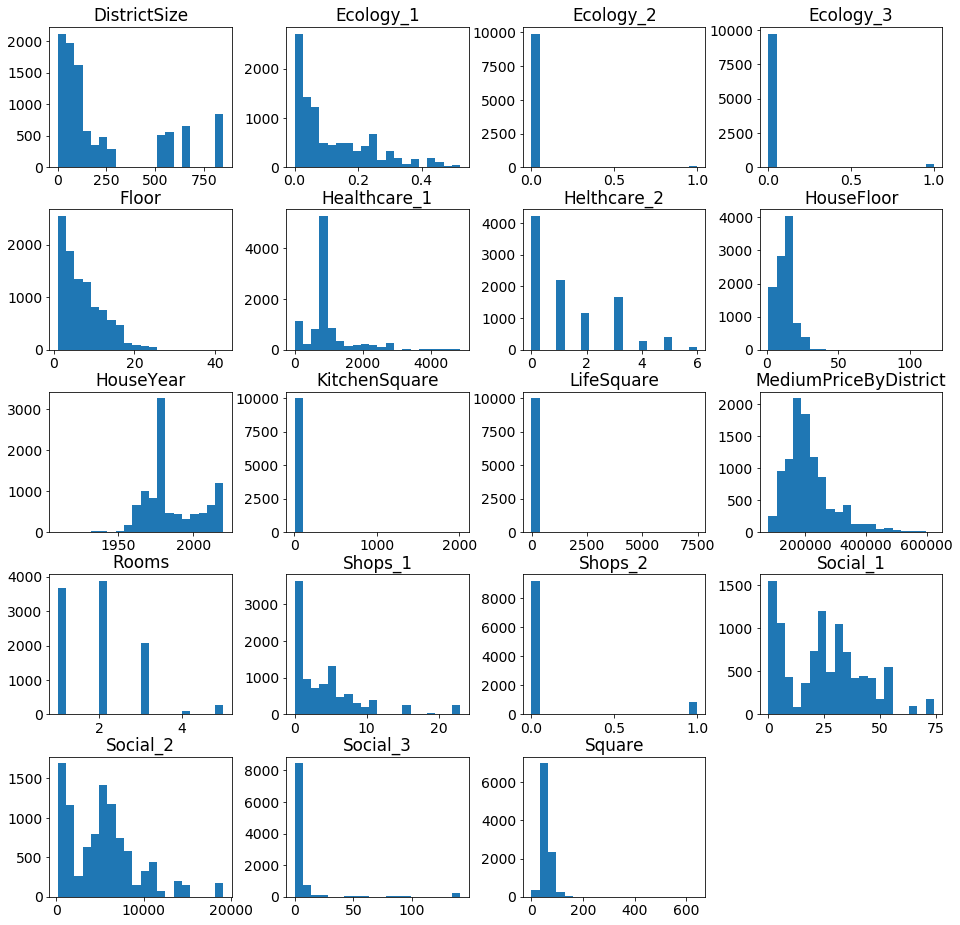

In [81]:
train_df_num_features.hist(figsize=(16,16),bins=20,grid=False)

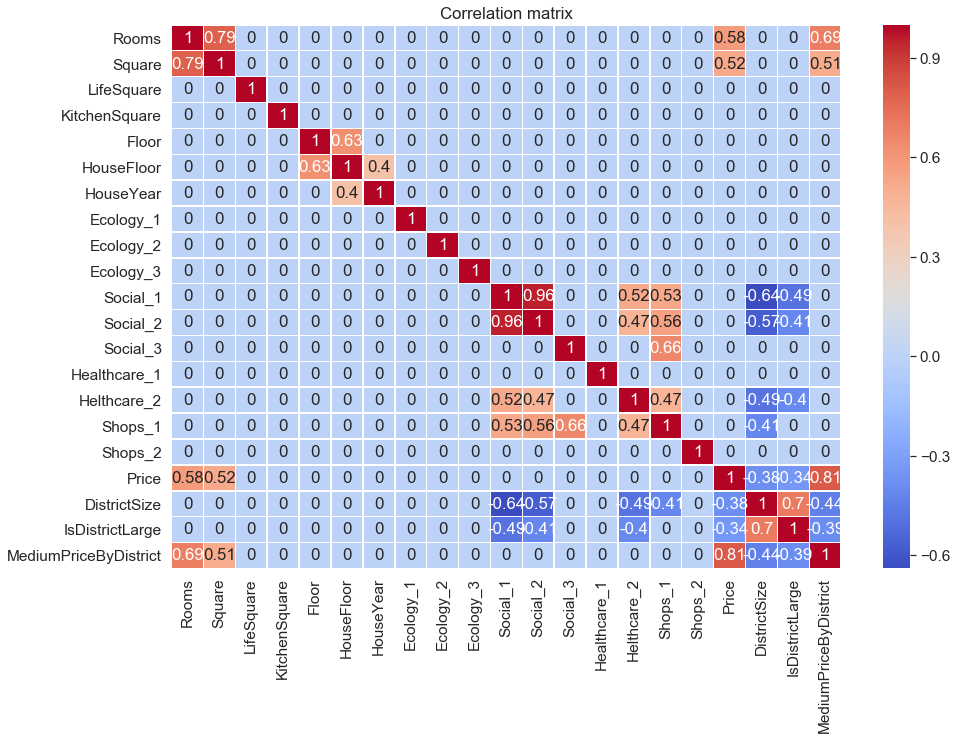

In [82]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

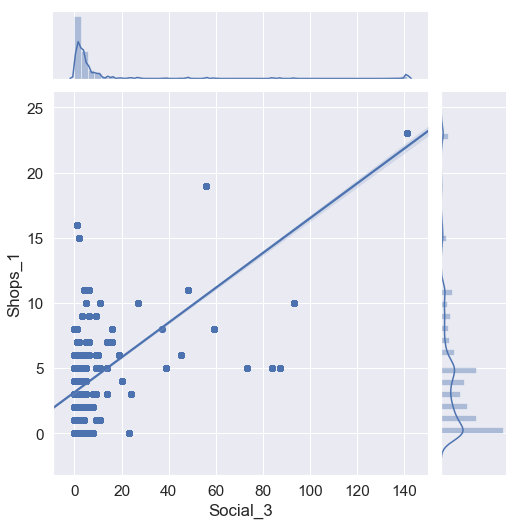

In [83]:
grid = sns.jointplot(train_df['Social_3'], train_df['Shops_1'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### Отбор признаков

In [84]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'MediumPriceByDistrict']

In [85]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['IsDistrictLarge', 'MediumPriceByDistrict','DistrictSize']

target_name = 'Price'


### Разбиение на train и val

In [86]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [87]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.33, shuffle=True,random_state=21)

### Построение модели

#### Обучение и оценка модели

####  GradientBoosting

In [88]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [89]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 1min 32s


In [90]:
res = pd.DataFrame(gs.cv_results_)
res.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.568,0.058,0.006,3.000e-03,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.736,0.723,0.746,0.748,0.744,0.740,0.009,12,0.774,0.776,0.773,0.772,0.771,0.773,0.002
1,0.929,0.018,0.012,8.440e-03,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.748,0.739,0.760,0.759,0.759,0.753,0.008,4,0.805,0.806,0.803,0.802,0.799,0.803,0.002
2,1.610,0.054,0.008,3.990e-04,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.748,0.747,0.768,0.758,0.765,0.757,0.009,1,0.832,0.834,0.832,0.827,0.829,0.831,0.002
3,3.285,0.136,0.019,6.543e-03,3,400,"{'max_depth': 3, 'n_estimators': 400}",0.741,0.745,0.769,0.754,0.766,0.755,0.011,3,0.866,0.865,0.865,0.861,0.862,0.864,0.002
4,1.067,0.061,0.007,3.373e-03,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.741,0.737,0.765,0.759,0.756,0.752,0.011,6,0.843,0.843,0.840,0.838,0.837,0.840,0.002
5,1.813,0.064,0.007,4.892e-04,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.744,0.742,0.770,0.759,0.763,0.755,0.011,2,0.873,0.871,0.872,0.867,0.871,0.871,0.002
6,3.115,0.057,0.013,1.197e-03,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.740,0.739,0.767,0.752,0.764,0.753,0.012,5,0.907,0.901,0.907,0.902,0.904,0.904,0.002
7,5.500,0.178,0.022,1.466e-03,5,400,"{'max_depth': 5, 'n_estimators': 400}",0.730,0.731,0.764,0.742,0.758,0.745,0.014,9,0.941,0.937,0.938,0.933,0.940,0.938,0.003
8,1.544,0.108,0.007,7.474e-04,7,50,"{'max_depth': 7, 'n_estimators': 50}",0.729,0.739,0.764,0.745,0.760,0.747,0.013,7,0.897,0.894,0.892,0.900,0.894,0.895,0.003
9,2.610,0.090,0.011,1.850e-03,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.725,0.738,0.763,0.743,0.761,0.746,0.014,8,0.927,0.920,0.923,0.923,0.922,0.923,0.002


In [91]:
gs.best_params_

{'max_depth': 3, 'n_estimators': 200}

In [92]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=100)

gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Train R2:	0.917
Valid R2:	0.775


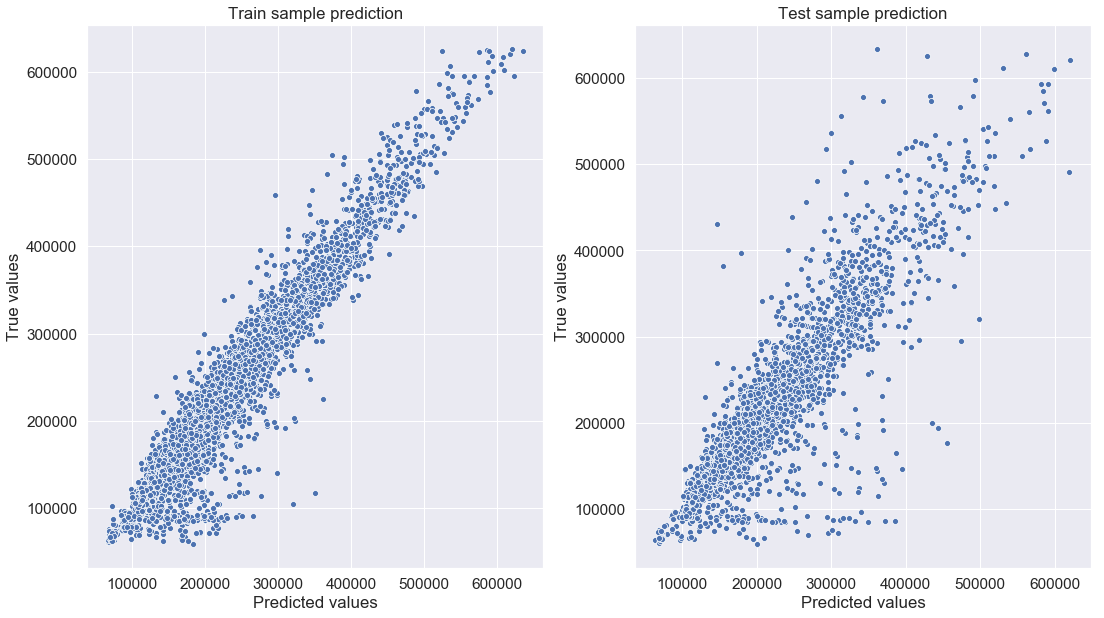

In [93]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### RandomForest

In [94]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=21, verbose=0, warm_start=False)

Train R2:	0.953
Valid R2:	0.741


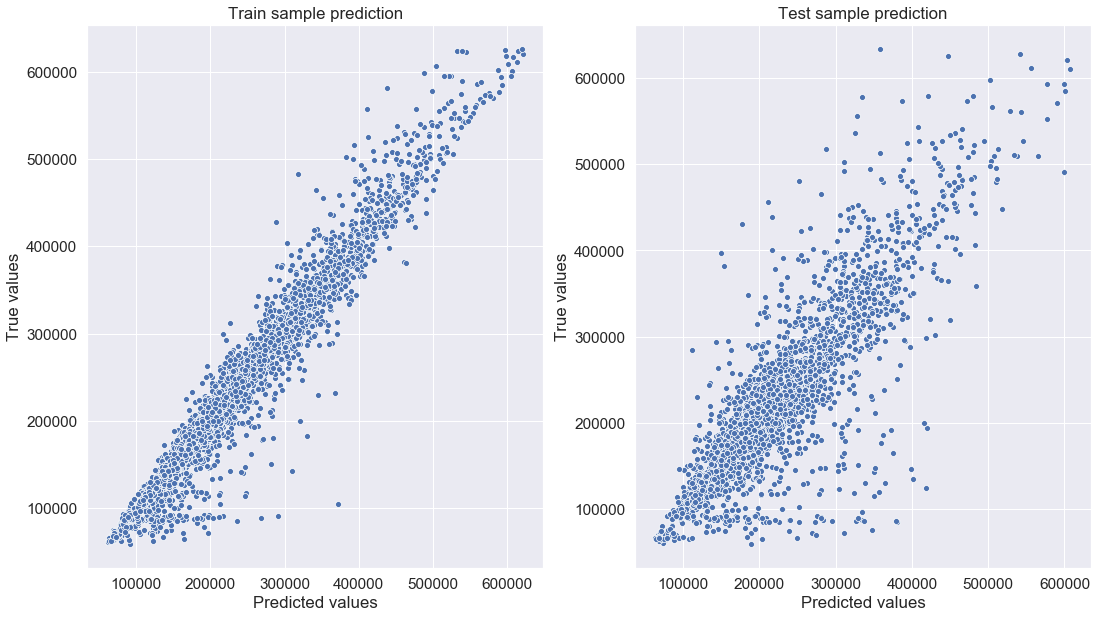

In [95]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Перекрестная проверка

In [96]:
cv_score = cross_val_score(rf_model,X,y, scoring='r2',cv=KFold(n_splits=3,shuffle=True,random_state=21))
cv_score

array([0.73717664, 0.7323735 , 0.74712513])

In [97]:
cv_score.mean()

0.7388917552286124

In [98]:
gb_model.feature_importances_

array([6.27854295e-03, 9.33128357e-02, 1.78455784e-02, 2.18035511e-02,
       1.62918293e-02, 1.65292663e-02, 2.58862674e-02, 1.12527562e-02,
       0.00000000e+00, 2.49473998e-04, 9.75089031e-03, 1.44340292e-02,
       2.27719423e-02, 1.00478317e-02, 3.25232725e-03, 4.61649280e-03,
       3.85008521e-04, 3.23676619e-04, 7.07853545e-01, 1.71141554e-02])

In [99]:
feature_importances = pd.DataFrame(list(zip(X_train.columns, rf_model.feature_importances_)), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MediumPriceByDistrict,6.579e-01
1,Square,1.038e-01
6,HouseYear,2.834e-02
2,LifeSquare,2.503e-02
5,HouseFloor,2.478e-02
19,DistrictSize,2.311e-02
4,Floor,2.270e-02
12,Social_3,2.188e-02
3,KitchenSquare,2.051e-02
11,Social_2,1.482e-02


In [100]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

# Test

### Rooms

In [101]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [102]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [103]:
test_df.loc[test_df['Rooms'].isin([0,6,17]),'Rooms'] = test_df['Rooms'].median()

### Square,LifeSquare,KitchenSquare

In [104]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000,5000.000,3959.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,2623.000,5000.000,5000.000
mean,1.906,56.450,36.159,5.977,8.632,12.601,1984.393,0.120,24.934,5406.900,8.263,1146.657,1.319,4.243
std,0.806,19.093,17.825,9.950,5.483,6.789,18.573,0.120,17.532,4026.615,23.864,1044.744,1.480,4.777
min,1.000,1.379,0.333,0.000,1.000,0.000,1908.000,0.000,0.000,168.000,0.000,0.000,0.000,0.000
25%,1.000,41.906,23.092,1.000,4.000,9.000,1973.000,0.020,6.000,1564.000,0.000,325.000,0.000,1.000
50%,2.000,52.921,32.925,6.000,7.000,12.000,1977.000,0.072,25.000,5285.000,2.000,900.000,1.000,3.000
75%,2.000,66.285,45.174,9.000,12.000,17.000,2000.000,0.196,36.000,7287.000,5.000,1548.000,2.000,6.000
max,5.000,223.454,303.071,620.000,78.000,99.000,2020.000,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000


In [106]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000,5000.000,3959.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,2623.000,5000.000,5000.000
mean,1.906,56.450,36.159,5.977,8.632,12.601,1984.393,0.120,24.934,5406.900,8.263,1146.657,1.319,4.243
std,0.806,19.093,17.825,9.950,5.483,6.789,18.573,0.120,17.532,4026.615,23.864,1044.744,1.480,4.777
min,1.000,1.379,0.333,0.000,1.000,0.000,1908.000,0.000,0.000,168.000,0.000,0.000,0.000,0.000
25%,1.000,41.906,23.092,1.000,4.000,9.000,1973.000,0.020,6.000,1564.000,0.000,325.000,0.000,1.000
50%,2.000,52.921,32.925,6.000,7.000,12.000,1977.000,0.072,25.000,5285.000,2.000,900.000,1.000,3.000
75%,2.000,66.285,45.174,9.000,12.000,17.000,2000.000,0.196,36.000,7287.000,5.000,1548.000,2.000,6.000
max,5.000,223.454,303.071,620.000,78.000,99.000,2020.000,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000


In [107]:
test_df.loc[test_df['LifeSquare'] < 10,'LifeSquare'] = 10

In [108]:
test_df.loc[test_df['KitchenSquare'] < 3,'KitchenSquare'] = 3

In [109]:
pd.pivot_table(data=test_df,
               values='Square',
               index='Rooms',
               aggfunc='mean')

,Square
Rooms,
1.0,40.943
2.0,56.835
3.0,77.201
4.0,94.501
5.0,115.789


### HouseFloor,Floor

In [110]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [111]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [112]:
test_df.loc[test_df['HouseFloor']==0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [113]:
floor_outliers = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[floor_outliers,'Floor'] = test_df.loc[floor_outliers,'HouseFloor'].apply(lambda x:random.randint(1,x))

In [114]:
test_df[test_df['Floor'] > test_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


### HouseYear

In [115]:
test_df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

### Обработка пропусков

In [116]:
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

### LifeSquare

In [117]:
test_df['LifeSquare'].median()

32.92508663208161

In [118]:
test_df.loc[test_df['LifeSquare'].isnull(),'LifeSquare'] = (
test_df.loc[test_df['LifeSquare'].isnull(),'Square']
- test_df.loc[test_df['LifeSquare'].isnull(),'KitchenSquare']
-square_med_diff)

In [119]:
test_df['LifeSquare'].median()

34.07274220544646

In [120]:
test_df.loc[test_df['Healthcare_1'].isnull(),'Healthcare_1'] = test_df['Healthcare_1'].median()

In [121]:
test_df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

### Построение новых признаков

In [122]:
test_df.Ecology_2.replace(['A', 'B'], [1, 0], inplace=True) 
test_df.Ecology_3.replace(['A', 'B'], [1, 0], inplace=True)
test_df.Shops_2.replace(['A', 'B'], [1, 0], inplace=True) 

#### DistrictSize

In [123]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [124]:
test_df = test_df.merge(district_size,on='DistrictId',how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
0,725,58,2.0,49.883,33.433,6.0,6,14.0,1972,0.310,0,0,11,2748,1,900.0,0,0,0,91
1,15856,74,2.0,69.263,54.902,3.0,1,1.0,1977,0.076,0,0,6,1437,3,900.0,0,2,0,61
2,5480,190,1.0,13.598,15.948,12.0,2,5.0,1909,0.000,0,0,30,7538,87,4702.0,5,5,0,2
3,15664,47,2.0,73.047,51.941,9.0,22,22.0,2007,0.102,0,0,23,4583,3,900.0,3,3,0,49
4,14275,27,1.0,47.527,43.388,3.0,17,17.0,2017,0.072,0,0,2,629,1,900.0,0,0,1,391


In [125]:
test_df['IsDistrictLarge'] = (test_df['DistrictSize']>100).astype(int)

#### MediumPriceByDistrict

In [126]:
test_df = test_df.merge(medium_price_by_district,on=['DistrictId','Rooms'],how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize,IsDistrictLarge,MediumPriceByDistrict
0,725,58,2.0,49.883,33.433,6.0,6,14.0,1972,0.310,0,0,11,2748,1,900.0,0,0,0,91,0,166809.666
1,15856,74,2.0,69.263,54.902,3.0,1,1.0,1977,0.076,0,0,6,1437,3,900.0,0,2,0,61,0,243031.696
2,5480,190,1.0,13.598,15.948,12.0,2,5.0,1909,0.000,0,0,30,7538,87,4702.0,5,5,0,2,0,NaN
3,15664,47,2.0,73.047,51.941,9.0,22,22.0,2007,0.102,0,0,23,4583,3,900.0,3,3,0,49,0,222227.584
4,14275,27,1.0,47.527,43.388,3.0,17,17.0,2017,0.072,0,0,2,629,1,900.0,0,0,1,391,1,118327.091


In [127]:
test_df['MediumPriceByDistrict'].isnull().sum()

81

In [128]:
test_df.loc[test_df['MediumPriceByDistrict'].isnull(),'MediumPriceByDistrict']=test_df['MediumPriceByDistrict'].median()

In [129]:
test_df['MediumPriceByDistrict'].isnull().sum()

0

In [130]:
submit = pd.read_csv(r'C:\Users\Julia\.jupyter\input\sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [131]:
predictions = gb_model.predict(test_df[feature_names+new_feature_names])
predictions

array([150237.30017334, 238163.55082952, 266759.87342456, ...,
       318816.37986828, 197611.5554252 , 187516.69278077])

In [132]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,150237.300
1,15856,238163.551
2,5480,266759.873
3,15664,298972.719
4,14275,131336.868


In [133]:
submit.to_csv('rf_submit.csv', index=False)

## Сохранение модели

In [135]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(rf_model, file)

In [136]:
with open(MODEL_FILE_PATH, 'rb') as file:
    rf_model = pickle.load(file)
    
rf_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=21, verbose=0, warm_start=False)